### This notebook is the solutions of exercises of the book 'Analyzing Neural Time Series' by Mike X Cohen. Moreover, I add some experiments if I see them useful for study

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.io import loadmat

from mne import create_info, EvokedArray, find_layout
from mne.channels import make_dig_montage
from mne.viz import plot_topomap

### Data preparation

#### The data are from Cohen and Ridderinkhof (2013). A high-pass filter at 0.5 Hz was applied. The reference was placed on both earlobes. Next, the data were epoched. It was then cleaned manually and automatically using electrodes placed around the eyes and on a thumb to remove partial error, blink, and eye movement artifacts. Additionally, independent component analysis (ICA) was performed to exclude remaining artifacts.

In [14]:
eeg = loadmat('../sampleEEGdata.mat')['EEG'][0, 0] # orinally the data was from matlab

data_eeg = eeg["data"] # the main voltage data
pts_eeg = eeg["pnts"][0,0] # number of points in EEG data
times_eeg = eeg["times"][0] # time points
rate_eeg = float(eeg["srate"][0]) # rate
n_trails_eeg = eeg["trials"][0,0] # the number of trial
epoch_eeg = eeg["epoch"][0] # epoches

sph_rad = eeg['chanlocs'][0][0]['sph_radius'][0][0] # the radius of the head

ch_labels_eeg = [x[0] for x in eeg["chanlocs"][0]["labels"]] # the list of channels
ch_coords = np.vstack([-1*eeg['chanlocs']['Y'], eeg['chanlocs']['X'], eeg['chanlocs']['Z']]).T # the coordinates of channels
ch_coords = [[x[0][0][0], x[1][0][0], x[2][0][0]] for x in ch_coords] # 2D coordinates

/var/folders/w8/ttg_lnyx4dj8lfctwhbhd7xw0000gn/T/ipykernel_12078/1434132630.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rate_eeg = float(eeg["srate"][0]) #make float for division purposes later


In [7]:
# creating evoked array in MNE package for easy visualization
info_eeg = create_info(ch_labels_eeg, rate_eeg, ch_types='eeg')
evoked = EvokedArray(np.mean(data_eeg, axis=2), info_eeg, 
                     tmin=eeg['xmin'][0][0], nave=n_trails_eeg, 
                     kind='average')

# making the montage for visualization
montage = make_dig_montage(ch_pos=dict(zip(ch_labels_eeg, ch_coords)), coord_frame='head')
evoked.set_montage(montage)

<Evoked | '' (average, N=99), -1 – 1.4961 s, baseline off, 64 ch, ~410 kB>

### Single subject ERP

In [308]:
time_bounds = [-200, 1000]
ind_points = (times_eeg > time_bounds[0]) & (times_eeg < time_bounds[1])

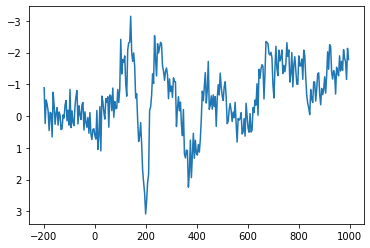

In [309]:
plt.plot(times_eeg[ind_points], np.mean(data_eeg[0], 1)[ind_points])
plt.gca().invert_yaxis()

### Topographical Plot (Exercise 9.8.1)

####  Compute the ERP at each electrode. Select five time points at which to show topographical plots (e.g., 0 to 400 ms in 100-ms steps). In one figure, make a series of topographical plots at these time points. To increase the signal-to-noise ratio, make each plot show the average of activity from 20 ms before until 20 ms after each time point. For example, the topographical plot from 200 ms should show average activity from 180 ms until 220 ms. Indicate the center time point in a title on each subplot.

In [39]:
# I choose six time points from 0 to 500ms 
inds_time = [np.argmin(np.abs(times_eeg - t)) for t in np.linspace(0, 500, 6)]

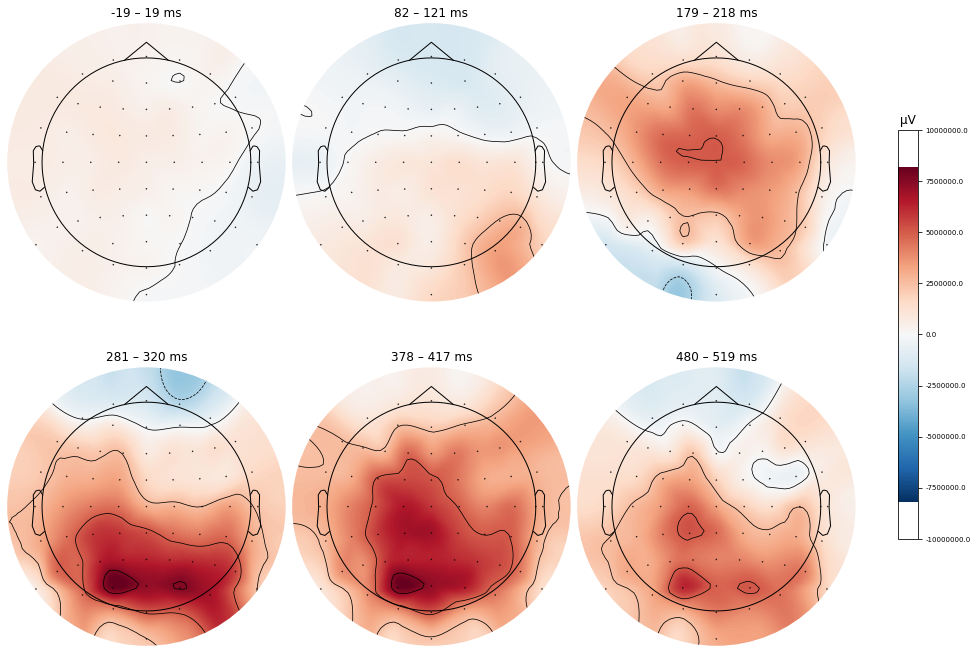

In [323]:
# Topographical Plot with averaged time windows 40ms
evoked.plot_topomap(times=evoked.times[inds_time], 
                    sphere=sph_rad,  
                    nrows=2,
                    average=0.04,
                    size=3,
                    time_unit='ms',
                    #names=evoked.times[inds_time]
                    );


### Exercise 9.8.2

####  Loop through each electrode and find the peak time of the ERP between 100 and 400 ms. Store these peak times in a separate variable and then make a topographical plot of the peak times (that is, the topographical map will illustrate times in milliseconds, not activity at peak times). Include a color bar in the figure and make sure to show times in milliseconds from time 0 (not, for example, time in milliseconds since 100 ms or indices instead of milliseconds). What areas of the scalp show the earliest and the latest peak responses to the stimulus within this window?

In [16]:
# Filtering the data which lies between 100 and 300ms
sel_time_bounds = [100, 300]

f_voltages = data_eeg[:,(times_eeg >= sel_time_bounds[0]) & (times_eeg <= sel_time_bounds[1])]
f_times = times_eeg[(times_eeg >= sel_time_bounds[0]) & (times_eeg <= sel_time_bounds[1])]

In [17]:
# I'm looking for positive peaks
t_peaks = f_times[np.argmax(f_voltages, axis=1)]

In [18]:
ch_pos_2D = np.array([[x, y] for x, y, z in ch_coords])

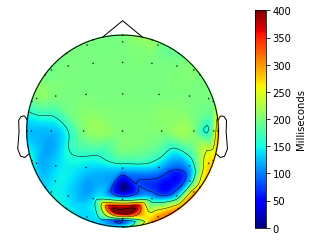

In [36]:
fig, ax = plt.subplots()

im, _ = plot_topomap(
                     data=t_peaks,
                     pos=ch_pos_2D,
                     axes=ax,
                     cmap='jet',
                     vlim=(0, 400),
                     sphere=sph_rad,
                     show=False
                     )



cbar = fig.colorbar(ax=ax, location='right', mappable=im)
cbar.set_label('Milliseconds')  # optional label

plt.show()

####  The peak first emerges in the parietal lobe and the left part of the temporal lobe, then spreads to the frontal lobe and other regions of the temporal lobe, and finally reaches the occipital lobes.